# HuBMAP - Efficient Sampling Baseline (deepflash2, pytorch, fastai) [sub]

> Training and submitting the model by sampling the valid region  

- Train Notebook: https://www.kaggle.com/matjes/hubmap-efficient-sampling-deepflash2-train
- Sampling Notebook: https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01

Requires deepflash2 (git version), zarr, and segmentation-models-pytorch


## Overview

1. Installation and loading package 
2. Helper functions and patches
3. Configuration
4. Predicted results
5. Submit results

### Versions
- V12: Minor changes in deepflash2 API to support albumentations (changes `apply`in `DeformationField` slightly, see patch below)
- V13: Adding prediction threshold 0.4

### Installation and loading package 

In [1]:
# Install deepflash2 and other dependent libraries
import sys
sys.path.append("../input/zarrkaggleinstall")
sys.path.append("../input/segmentation-models-pytorch-install")
!pip install -q --no-deps ../input/deepflash2-lfs
import cv2, torch, zarr, tifffile, pandas as pd, gc
from fastai.vision.all import *
from deepflash2.all import *
import segmentation_models_pytorch as smp

### Helper functions and patches

In [2]:
#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding

# masked images and transposed masked images
def rle_encode_less_memory(img):
    # Image pixels should be transposed, pixels are expanded into one dimensional data
    pixels = img.T.flatten()
    
    # This simplified method requires the first and last pixel to be 0
    pixels[0] = 0
    pixels[-1] = 0
    # to do
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    # to do
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def load_model_weights(model, file, strict=True):
    # Read PyTorch dataset by CPU method
    state = torch.load(file, map_location='cpu')
    stats = state['stats']
    model_state = state['model']
    model.load_state_dict(model_state, strict=strict)
    return model, stats

Patches for deepflash2 classes, see https://fastcore.fast.ai/basics.html#patch

In [3]:
# https://matjesg.github.io/deepflash2/data.html#BaseDataset
# Handling of different input shapes
@patch
def read_img(self:BaseDataset, *args, **kwargs):
    image = tifffile.imread(args[0])
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    elif image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return image

# https://matjesg.github.io/deepflash2/data.html#DeformationField
# Increase standardization (divide by 255) and distort images using interpolation
@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    # Confirm the shape output to be changed
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr), saving loading time 
    sl = []
    for i in range(len(coords)):
        # to do
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        # to do
        dmax = data.shape[i]
        # Adding qualifiers to Images
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        # Add the matching slices to the sl
        sl.append(slice(cmin, cmax))   
    # Extraction of empty slices
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        
        for c in range(data.shape[-1]):
            # Adding divide remapping
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

### Configuration

In [4]:
class CONFIG():
    
    # Data Path
    data_path = Path('../input/hubmap-kidney-segmentation')
    model_file = '../input/hubmap-efficient-sampling-deepflash2-train/unet_efficientnet-b4.pth'
    
    # deepflash2 dataset (https://matjesg.github.io/deepflash2/data.html#TileDataset)
    
    scale = 3 # zoom facor (zoom out)
    tile_shape = (512, 512) # Cut size
    padding = (100,100) # Border overlap warning

    # pytorch model links (https://github.com/qubvel/segmentation_models.pytorch)
    encoder_name = "efficientnet-b4"
    encoder_weights = None
    in_channels = 3 # Color image input channels are 3
    classes = 2    # Total category is 2
    
    # Batch size 
    batch_size = 16
    
    # Prediction threshold
    threshold = 0.4
# Configure according to the given configuration method    
cfg = CONFIG()

In [5]:
# ids-Sample submission
df_sample = pd.read_csv(cfg.data_path/'sample_submission.csv',  index_col='id')

# Model (see https://github.com/qubvel/segmentation_models.pytorch)
model = smp.Unet(encoder_name=cfg.encoder_name, 
                 encoder_weights=cfg.encoder_weights, 
                 in_channels=cfg.in_channels, 
                 classes=cfg.classes)
model, stats = load_model_weights(model, cfg.model_file)
batch_tfms = [Normalize.from_stats(*stats)]

### Predicted results

###### File 2ec3f1bb9 ######


Shape: (23990, 47723, 3)
Prediction


Rezising
Plotting


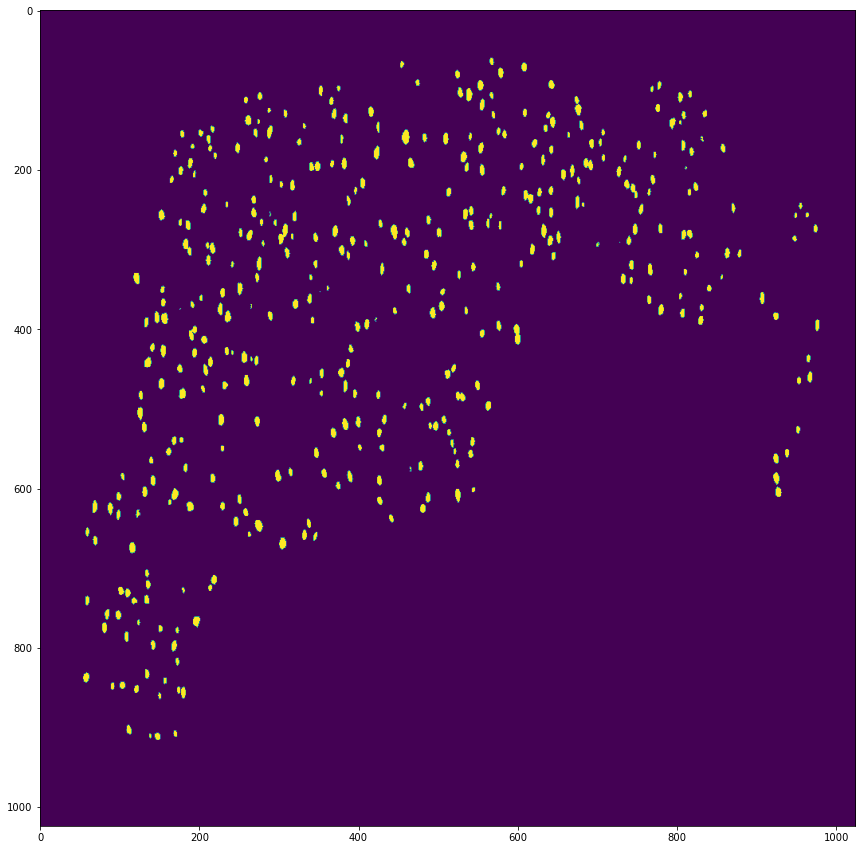

###### File 3589adb90 ######


Shape: (29433, 22165, 3)
Prediction


Rezising
Plotting


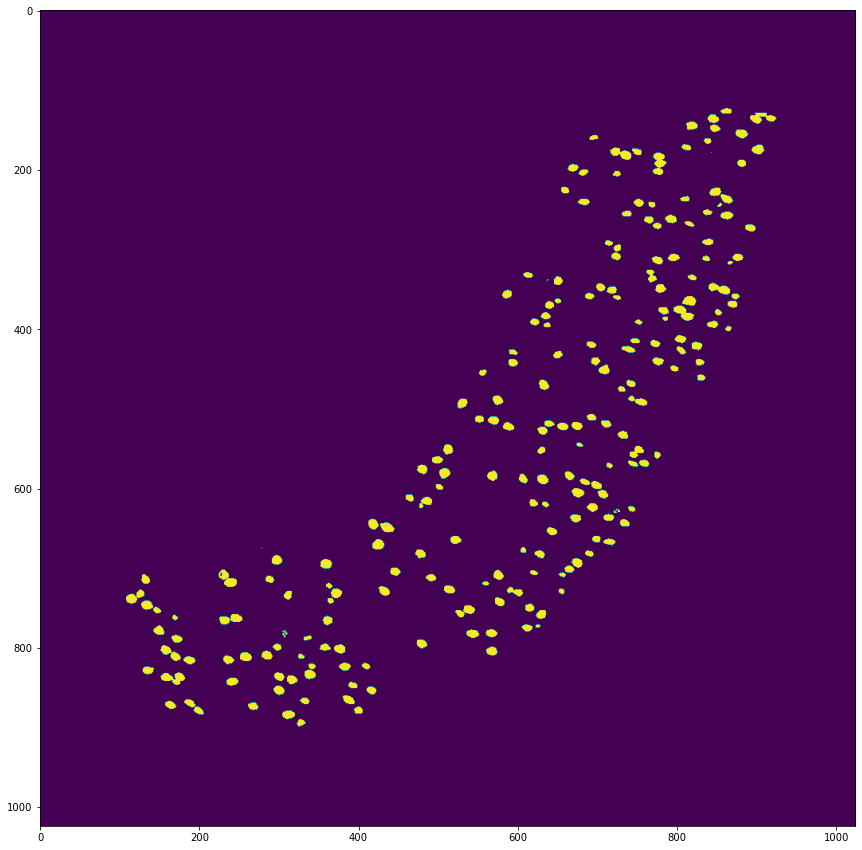

###### File d488c759a ######


Shape: (46660, 29020, 3)
Prediction


Rezising
Plotting


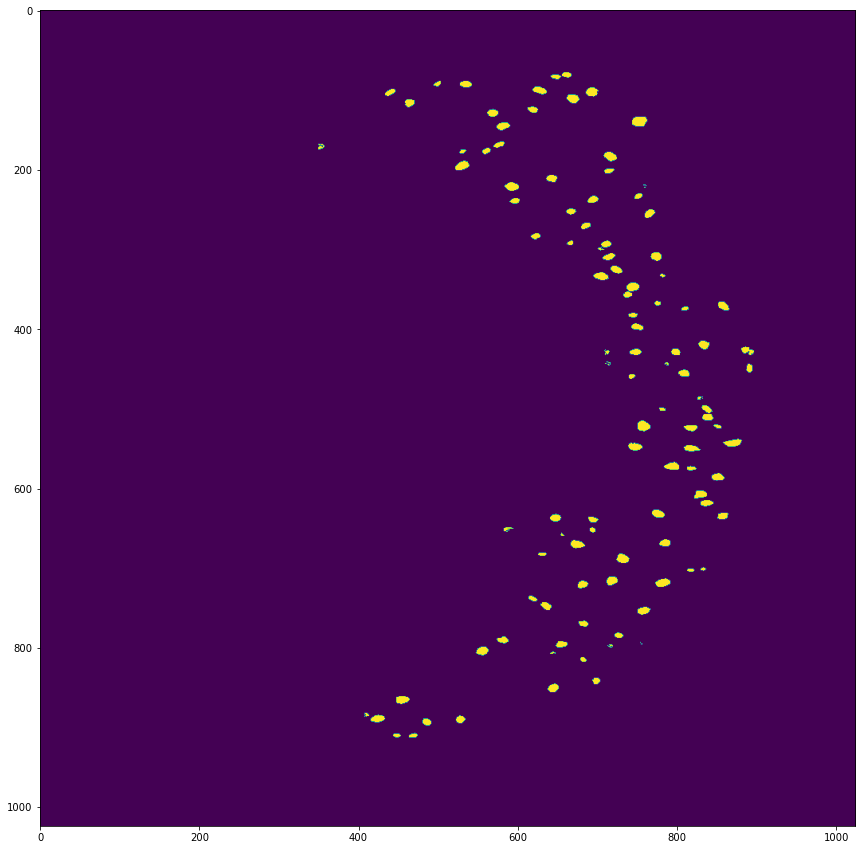

###### File aa05346ff ######


Shape: (30720, 47340, 3)
Prediction


Rezising
Plotting


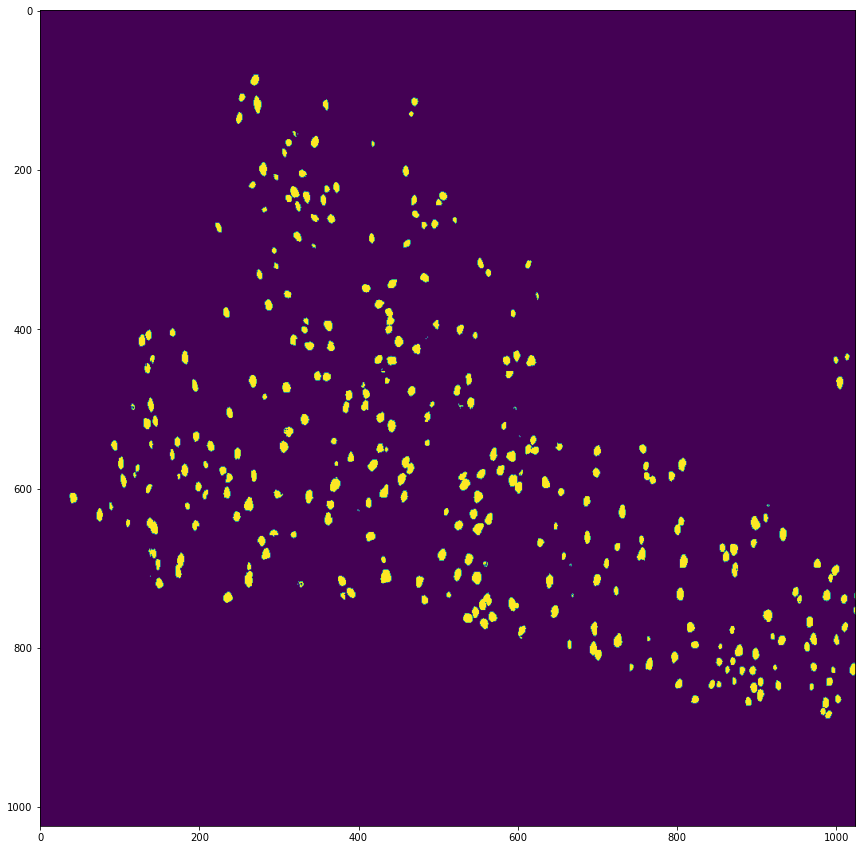

###### File 57512b7f1 ######


Shape: (33240, 43160, 3)
Prediction


Rezising
Plotting


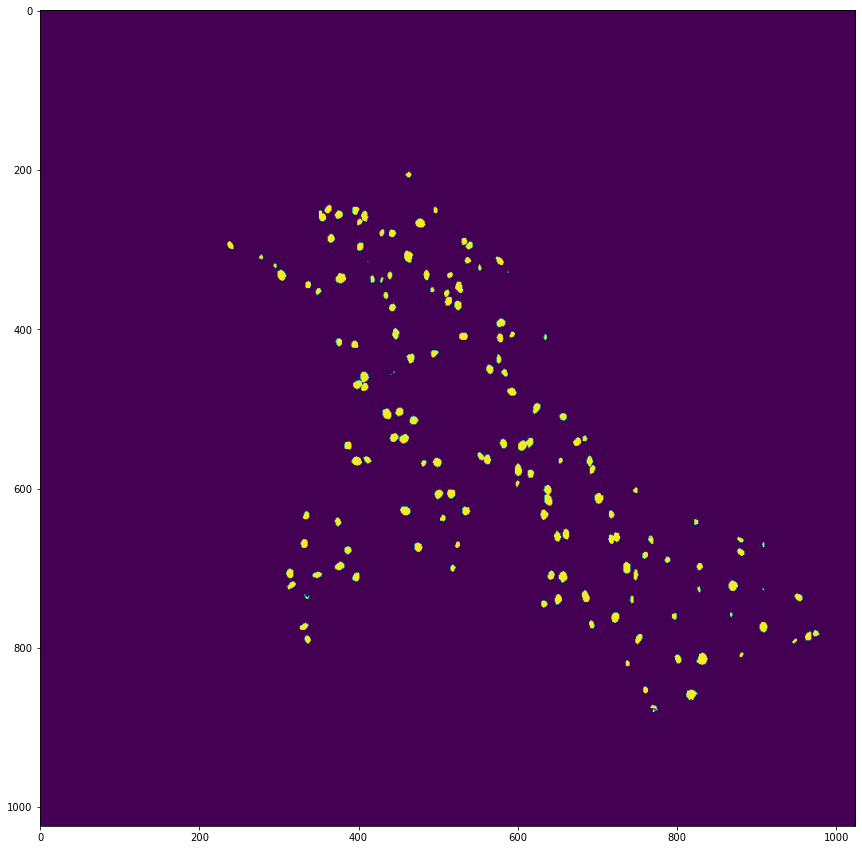

In [6]:
names,preds = [],[]


for idx, _ in df_sample.iterrows():
    print(f'###### File {idx} ######')
    # Displaying the test set as an image
    f = cfg.data_path/'test'/f'{idx}.tiff'
    
    # Create deepflash2 dataset (including sliced and transformed images)
    ds = TileDataset([f], scale=cfg.scale, tile_shape=cfg.tile_shape, padding=cfg.padding)
    shape = ds.data[f.name].shape
    print('Shape:', shape)
    
    # Create fastai-Data Readers and Learners
    dls = DataLoaders.from_dsets(ds, batch_size=cfg.batch_size, after_batch=batch_tfms, shuffle=False, drop_last=False)
    # Use GPU if it is available
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    learn = Learner(dls, model, loss_func='')
    
    # Predict tiles, see https://matjesg.github.io/deepflash2/learner.html#Learner.predict_tiles
    print('Prediction')
    res = learn.predict_tiles(dl=dls.train, path='/kaggle/temp/', use_tta=False, uncertainty_estimates=False)
    
    # Load mask from softmax prediction to threshold
    msk = (res[0][f.name][..., 1]>cfg.threshold).astype(np.uint8)
    print('Rezising')
    msk = cv2.resize(msk, (shape[1], shape[0]))
    rle = rle_encode_less_memory(msk)
    names.append(idx)
    preds.append(rle)
    
    # Display data results
    print('Plotting')
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(cv2.resize(res[1][f.name][:].astype(np.uint8), (1024, 1024)))
    plt.show()

    # Storage overlay (reduces hard drive usage)
    _ = [shutil.rmtree(p, ignore_errors=True) for p in Path('/kaggle/temp/').iterdir()]
    _ = [shutil.rmtree(p, ignore_errors=True) for p in Path('/tmp/').iterdir() if p.name.startswith('zarr')]

### Submit results

In [7]:
df = pd.DataFrame({'id':names,'predicted':preds}).set_index('id')
df_sample.loc[df.index.values] = df.values  
df_sample.to_csv('submission.csv')
display(df_sample)

,predicted
id,
2ec3f1bb9,60762298 2 60762301 2 60762304 2 60762307 2 60762310 2 60762313 2 60762316 2 60762319 2 60762322 2 60762325 1 60786287 30 60810277 30 60834250 2 60834253 2 60834256 2 60834259 2 60834262 2 60834265 32 60834298 2 60834301 2 60834304 2 60834307 2 60834310 2 60834313 1 60858239 66 60882229 66 60906211 2 60906214 2 60906217 68 60906286 2 60906289 2 60906292 2 60906295 2 60906298 1 60930200 90 60954190 90 60978169 2 60978172 2 60978175 2 60978178 92 60978271 2 60978274 2 60978277 2 60978280 1 61002158 114 61026148 114 61050130 2 61050133 2 61050136 116 61050253 2 61050256 1 61074119 129 6109810...
3589adb90,68452931 1 68452934 1 68452937 1 68452949 1 68452964 1 68452967 1 68452970 1 68452973 1 68452976 1 68452979 1 68452982 1 68452991 1 68482363 9 68482381 3 68482396 21 68482423 3 68511796 9 68511814 3 68511829 21 68511856 3 68541215 1 68541218 1 68541221 1 68541224 1 68541227 13 68541242 1 68541245 7 68541254 1 68541257 1 68541260 25 68541287 7 68541296 1 68570647 84 68600080 84 68629508 1 68629511 88 68658940 93 68688373 93 68717798 1 68717801 1 68717804 97 68717903 1 68717906 1 68747230 111 68776663 111 68806094 115 68806211 1 68835526 120 68864959 120 68894387 1 68894390 124 68894516 1 68...
d488c759a,461381726 1 461381729 1 461381732 1 461381735 1 461381738 1 461381741 1 461381744 1 461381747 1 461381750 1 461381753 1 461381756 1 461381759 1 461381762 1 461381765 1 461381768 1 461381771 1 461381774 1 461381777 1 461381780 1 461381783 1 461381786 1 461381789 1 461381792 1 461381795 1 461381798 1 461381801 1 461381804 1 461381807 1 461381813 1 461381819 1 461381822 1 461381825 1 461381828 1 461381831 1 461381834 1 461381837 1 461381855 1 461381858 1 461381861 1 461381864 1 461381867 1 461381870 1 461381873 1 461381876 1 461381879 1 461381882 1 461381885 1 461381888 1 461381891 1 46138189...
aa05346ff,52918136 1 52918139 1 52918142 1 52918145 1 52918148 1 52918151 1 52918154 1 52918157 1 52918160 1 52918163 1 52918166 1 52948855 33 52979575 33 53010281 1 53010284 1 53010287 1 53010290 1 53010293 37 53010332 1 53010335 1 53010338 1 53010341 1 53010344 1 53041000 66 53071720 66 53102417 1 53102420 1 53102423 1 53102426 1 53102429 1 53102432 1 53102435 1 53102438 70 53102510 1 53102513 1 53133136 99 53163856 99 53194565 1 53194568 1 53194571 1 53194574 103 53194679 1 53194682 1 53225284 120 53256004 120 53286713 1 53286716 1 53286719 1 53286722 124 53286848 1 53286851 1 53317432 141 533481...
57512b7f1,328985786 1 328985789 1 328985792 1 328985795 1 328985798 1 328985801 1 328985804 1 328985807 1 328985810 1 328985813 1 328985816 1 328985819 1 328985822 1 328985825 1 329019025 42 329052265 42 329085500 1 329085503 46 329085551 1 329085554 1 329085557 1 329118739 60 329151979 60 329185214 1 329185217 64 329185283 1 329185286 1 329185289 1 329185292 1 329185295 1 329218453 84 329251693 84 329284928 1 329284931 88 329285021 1 329318167 96 329351407 96 329384645 100 329384747 1 329417884 105 329451124 105 329484362 109 329484473 1 329517601 114 329550841 114 329584079 118 329584199 1 3296173...
